In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
import talib

plt.style.use('ggplot')

# 資料載入

In [2]:
df = pd.read_csv('TWF_Futures_Minute_Trade.txt')
df

,Date,Time,Open,High,Low,Close,TotalVolume
0,2009/1/5,08:46:00,4722.0,4745.0,4714.0,4727.0,1493
1,2009/1/5,08:47:00,4727.0,4728.0,4711.0,4716.0,608
2,2009/1/5,08:48:00,4713.0,4720.0,4713.0,4716.0,400
3,2009/1/5,08:49:00,4717.0,4722.0,4715.0,4718.0,457
4,2009/1/5,08:50:00,4719.0,4721.0,4718.0,4719.0,233
...,...,...,...,...,...,...,...
1971251,2022/5/23,09:10:00,16210.0,16216.0,16206.0,16214.0,452
1971252,2022/5/23,09:11:00,16215.0,16215.0,16207.0,16210.0,224
1971253,2022/5/23,09:12:00,16210.0,16220.0,16207.0,16218.0,478
1971254,2022/5/23,09:13:00,16218.0,16220.0,16212.0,16218.0,240


In [3]:
settlementDate_ = pd.read_csv('settlementDate.csv', encoding = 'big5')
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2022/8/31,202208W5,15078
1,2022/8/24,202208W4,15097
2,2022/8/17,202208,15452
3,2022/8/10,202208W2,14945
4,2022/8/3,202208W1,14707
...,...,...,...
512,2009/12/16,200912,7752
513,2009/11/18,200911,7786
514,2009/10/21,200910,7705
515,2009/9/16,200909,7445


In [4]:
ftr = pd.read_csv('foi&pc_ratio.csv')
ftr.index = pd.to_datetime(ftr.Date)
ftr = ftr.drop(columns = ['Date'])
ftr

,外資未平倉,PC ratio
Date,,
2007-07-02,-6558,94.00
2007-07-03,-7244,99.37
2007-07-04,-10093,107.74
2007-07-05,-11282,112.52
2007-07-06,-11925,115.57
...,...,...
2022-06-06,8528,105.68
2022-06-07,6617,99.09
2022-06-08,9587,107.31


# 資料處裡

日k整理

In [5]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)
df

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 08:49:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 08:50:00,4719.0,4721.0,4718.0,4719.0,233,8
...,...,...,...,...,...,...
2022-05-23 09:10:00,16210.0,16216.0,16206.0,16214.0,452,9
2022-05-23 09:11:00,16215.0,16215.0,16207.0,16210.0,224,9
2022-05-23 09:12:00,16210.0,16220.0,16207.0,16218.0,478,9
2022-05-23 09:13:00,16218.0,16220.0,16212.0,16218.0,240,9


In [6]:
Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 08:49:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 08:50:00,4719.0,4721.0,4718.0,4719.0,233,8
...,...,...,...,...,...,...
2022-05-23 09:10:00,16210.0,16216.0,16206.0,16214.0,452,9
2022-05-23 09:11:00,16215.0,16215.0,16207.0,16210.0,224,9
2022-05-23 09:12:00,16210.0,16220.0,16207.0,16218.0,478,9
2022-05-23 09:13:00,16218.0,16220.0,16212.0,16218.0,240,9


In [7]:
Morning=Morning.drop(columns=['Hour'])
daily = Morning.resample("B").agg(dict(zip(Morning.columns,["first", "max", "min", "last", "sum"])))
daily = daily[daily["close"].isna()==False].copy()
daily

,open,high,low,close,volume
2009-01-05,4722.0,4797.0,4634.0,4670.0,97869
2009-01-06,4699.0,4735.0,4638.0,4706.0,90227
2009-01-07,4758.0,4802.0,4711.0,4752.0,90777
2009-01-08,4650.0,4650.0,4434.0,4452.0,95219
2009-01-09,4447.0,4495.0,4344.0,4374.0,146382
...,...,...,...,...,...
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478


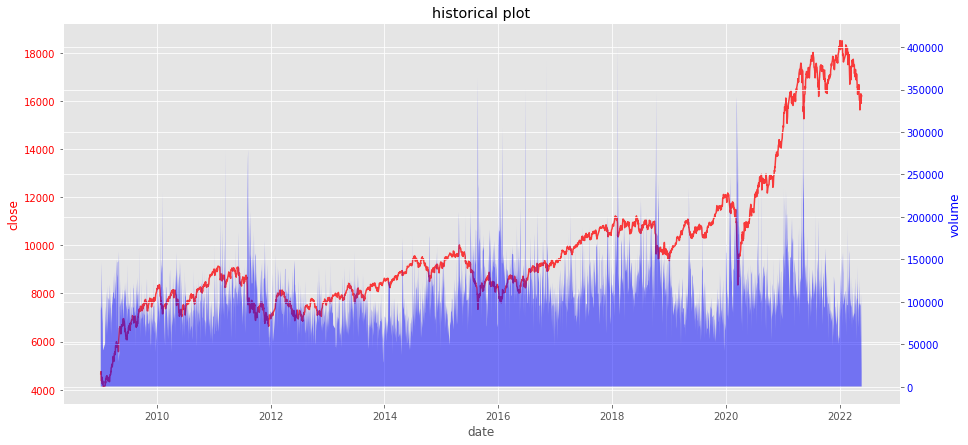

In [8]:
fig, ax1 = plt.subplots(figsize = (15,7))
plt.title('historical plot')
plt.xlabel('date')
ax2 = ax1.twinx()
ax1.set_ylabel('close', color='red')
ax1.plot(daily.close, color='red', alpha=0.75)
ax1.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('volume', color='blue')
ax2.fill_between(daily.index, daily.volume, 100, facecolor  = 'blue', label = 'volume', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='blue')

In [9]:
daily = pd.concat([daily, ftr], axis = 1, join = 'inner').dropna()
daily = daily.rename(columns = dict(zip(daily.columns, ['Open', 'High', 'Low', 'Close', 'Volume','Foreign_OI','PC_ratio']))) 
daily

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2009-01-05,4722.0,4797.0,4634.0,4670.0,97869,11435,66.79
2009-01-06,4699.0,4735.0,4638.0,4706.0,90227,12294,68.42
2009-01-07,4758.0,4802.0,4711.0,4752.0,90777,14821,70.11
2009-01-08,4650.0,4650.0,4434.0,4452.0,95219,15009,64.57
2009-01-09,4447.0,4495.0,4344.0,4374.0,146382,18302,64.13
...,...,...,...,...,...,...,...
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752,91,96.15
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713,1701,103.66
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113,400,88.47
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478,5593,96.77


In [20]:
trainData = daily[(daily.index >= '2011-01-01 00:00:00') & (daily.index <= '2019-12-31 00:00:00')].copy()
testData = daily[(daily.index >= '2020-1-1 00:00:00') & (daily.index <= '2022-5-22 00:00:00')].copy()

In [21]:
trainData.head(5)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365,-12611,128.13
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448,-14207,126.30
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831,-15303,117.69
2011-01-06,8859.0,8876.0,8815.0,8869.0,82510,-15135,114.87
2011-01-07,8866.0,8883.0,8727.0,8753.0,128752,-11883,113.53


In [22]:
testData.tail(5)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2022-05-16,15996.0,16044.0,15847.0,15921.0,97948,-2540,89.74
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752,91,96.15
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713,1701,103.66
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113,400,88.47
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478,5593,96.77


結算日

In [23]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]
settlementDate[-5:]

[datetime.date(2009, 12, 16),
 datetime.date(2009, 11, 18),
 datetime.date(2009, 10, 21),
 datetime.date(2009, 9, 16),
 datetime.date(2009, 8, 19)]

# 回測

In [24]:
fund = 1000000
feePaid = 600
K = 0.04
d = 0.02

In [67]:
plus = talib.PLUS_DI(trainData['High'], trainData['Low'], trainData['Close'], timeperiod=14)
minus = talib.MINUS_DI(trainData['High'], trainData['Low'], trainData['Close'], timeperiod=14)
trainData['diff'] = plus - minus
trainData['diff_avg'] = talib.SMA(diff, timeperiod=60)
trainData['ADX'] = talib.ADX(trainData['High'], trainData['Low'], trainData['Close'], timeperiod=14)

In [68]:
trainData.tail(10)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio,diff,diff_avg,ADX
2019-12-18,12076.0,12129.0,12065.0,12118.0,47948,43908,134.28,34.532564,15.151925,31.809472
2019-12-19,12110.0,12115.0,12015.0,12030.0,92203,42487,112.46,28.379220,15.423451,33.070184
2019-12-20,12063.0,12063.0,11951.0,11979.0,126726,41003,106.42,21.553414,15.602265,33.392008
2019-12-23,12000.0,12028.0,11972.0,12020.0,75282,40668,108.72,20.665293,15.864031,33.690844
2019-12-24,12030.0,12044.0,11982.0,11983.0,55383,37093,105.19,20.906049,16.103726,34.068812
2019-12-25,11989.0,12027.0,11976.0,12020.0,41574,37184,122.63,19.604727,16.353290,34.330255
2019-12-26,12029.0,12042.0,11986.0,12009.0,52147,34859,123.62,19.927742,16.529895,34.678459
2019-12-27,12038.0,12112.0,12037.0,12097.0,74436,38443,138.47,23.857355,16.777438,35.464042
2019-12-30,12091.0,12125.0,12065.0,12069.0,66060,38158,129.88,23.750413,17.224313,36.274399
2019-12-31,12029.0,12049.0,11992.0,11995.0,74341,36910,113.18,16.257326,17.496473,35.852932


In [69]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

             profit  profitfee
2011-01-03      0.0        0.0
2011-01-04      0.0        0.0
2011-01-05      0.0        0.0
2011-01-06      0.0        0.0
2011-01-07      0.0        0.0
...             ...        ...
2019-12-25 -44400.0  -124800.0
2019-12-26 -36400.0  -116800.0
2019-12-27 -34600.0  -115000.0
2019-12-30 -24000.0  -104400.0
2019-12-31 -36400.0  -118000.0

[2197 rows x 2 columns]


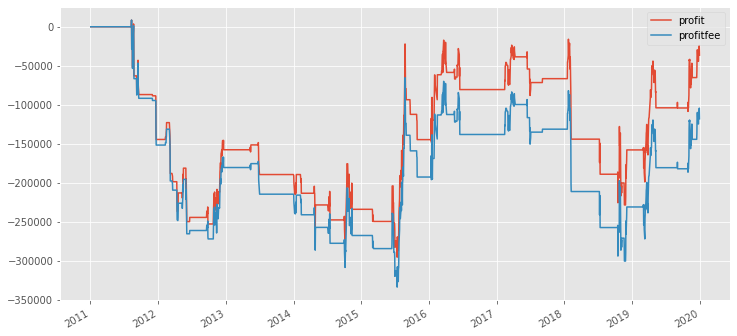

In [70]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = (df_arr[i,7] > df_arr[i,8]) & (df_arr[i,6] >= 110) & (df_arr[i,-1] > 25)
    entrySellShort = (df_arr[i,7] < df_arr[i,8]) & (df_arr[i,6] <= 90) & (df_arr[i,-1] > 25)
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = ((df_arr[i,7] <= df_arr[i,8]) & (df_arr[i,6] <= 110)) or (df_arr[i,-1] <= 25)
    exitBuyToCover = (df_arr[i,7] >= df_arr[i,8]) & (df_arr[i,6] >= 90) or (df_arr[i,-1] <= 25)
    exitCondition = date_arr[i] in settlementDate  ####
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-d)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+d)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));

In [71]:
print(buy)
print(sell)
print(sellshort)
print(buytocover)

[268, 282, 291, 342, 356, 420, 423, 469, 483, 574, 735, 806, 857, 940, 1016, 1156, 1179, 1246, 1248, 1264, 1273, 1317, 1323, 1490, 1494, 1512, 1568, 1579, 1628, 1721, 1723, 1925, 1931, 1988, 2003, 2021, 2114, 2150, 2185, 2189]
[273, 285, 293, 345, 357, 422, 427, 482, 486, 578, 746, 812, 866, 948, 1021, 1158, 1182, 1247, 1251, 1272, 1284, 1318, 1332, 1493, 1511, 1527, 1571, 1584, 1629, 1722, 1736, 1927, 1936, 2002, 2020, 2035, 2116, 2168, 2188, 2196]
[146, 151, 153, 166, 225, 237, 308, 312, 328, 446, 604, 756, 918, 930, 1088, 1092, 1098, 1106, 1110, 1118, 1135, 1138, 1141, 1234, 1312, 1832, 1900, 1907]
[150, 152, 156, 173, 226, 240, 311, 314, 333, 466, 609, 759, 928, 937, 1091, 1096, 1101, 1109, 1117, 1133, 1137, 1140, 1142, 1240, 1314, 1836, 1903, 1917]


In [61]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

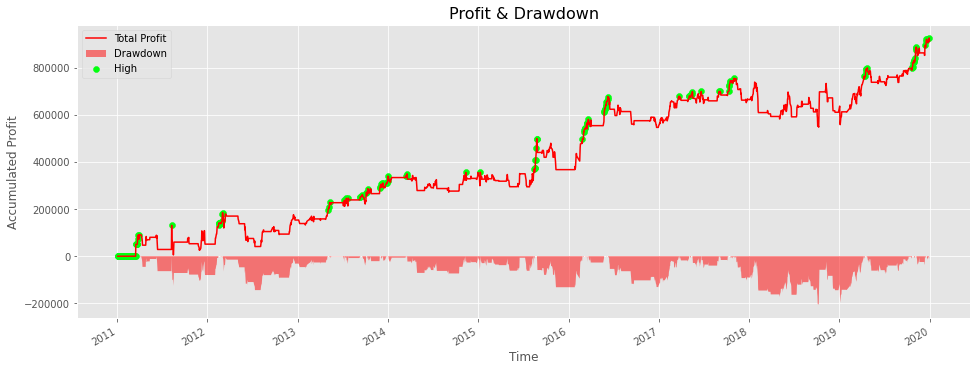

In [62]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

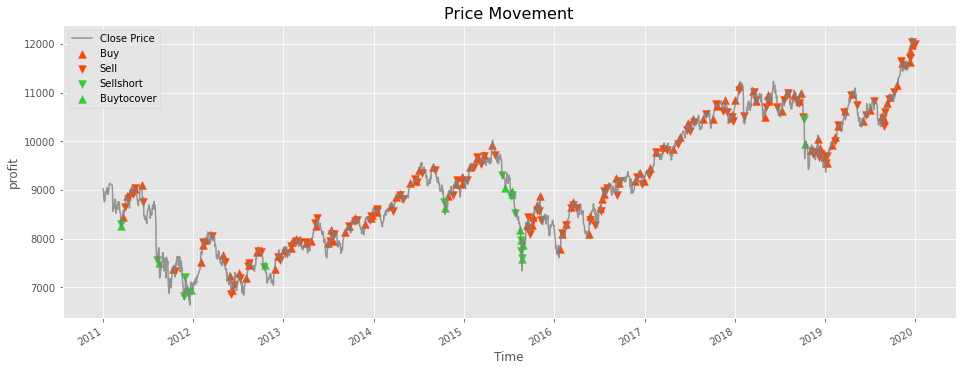

In [63]:
fig, ax = plt.subplots(figsize = (16,6))

trainData['Close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(trainData['Close'].iloc[buy].index, trainData['Close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(trainData['Close'].iloc[sell].index, trainData['Close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(trainData['Close'].iloc[sellshort].index, trainData['Close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(trainData['Close'].iloc[buytocover].index, trainData['Close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('profit')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [64]:
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $911800.0
return: 91.18%
mdd: 12.139999999999999%
calmarRatio: 7.51
tradeTimes: 136
winRate: 56.620000000000005%
profitFactor: 1.63
winLossRatio: 1.23


# 最佳化

In [42]:
optimizationList = []

fund = 1000000
feePaid = 600
K = 0.04
d = 0.02
rule = '1D'

for f in range(7,15,1):
    for s in range(20, 65, 5):
        for h in range(105,140,5):
            for l in range(65,100,5):
                print('----------')
                print(f'dmi_window: {f}')
                print(f'adx臨界值: {s}')
                print(f'pc_ratio high: {h}')
                print(f'pc_ratio low: {l}')
                data = trainData.iloc[:,:7].copy()
                
                plus = talib.PLUS_DI(data['High'], data['Low'], data['Close'], timeperiod=f)
                minus = talib.MINUS_DI(data['High'], data['Low'], data['Close'], timeperiod=f)
                data['diff'] = plus - minus
                data['diff_avg'] = talib.SMA(diff, timeperiod=s)
                data['ADX'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=f)

                time_arr = np.array(data.index)
                df_arr = np.array(data)
        

                BS = None
                buy = []
                sell = []
                sellshort = []
                buytocover = []
                profit_list = [0]
                profit_fee_list = [0]
                profit_fee_list_realized = []

                for i in range(len(df_arr)):
                    if i == len(df_arr)-1:
                        break
        
                ## 進場邏輯
                    entryLong = (df_arr[i,7] > df_arr[i,8]) & (df_arr[i,6] >= h) & (df_arr[i,-1] > 25)
                    entrySellShort = (df_arr[i,7] < df_arr[i,8]) & (df_arr[i,6] <= l) & (df_arr[i,-1] > 25)
                    entryCondition = date_arr[i] not in settlementDate
    
                ## 出場邏輯
                    exitShort = ((df_arr[i,7] <= df_arr[i,8]) & (df_arr[i,6] <= l)) or (df_arr[i,-1] <= 25)
                    exitBuyToCover = ((df_arr[i,7] >= df_arr[i,8]) & (df_arr[i,6] >= h)) or (df_arr[i,-1] <= 25)
                    exitCondition = date_arr[i] in settlementDate
    
                ## 停利停損邏輯
                    if BS == 'B':
                        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-d)
                        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
                    elif BS == 'S':
                        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+d)
                        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

                    if BS == None:
                        profit_list.append(0)
                        profit_fee_list.append(0)
         
                        if entryLong and entryCondition:
                            BS = 'B'
                            t = i+1
                            buy.append(t)

                        elif entrySellShort and entryCondition:
                            BS = 'S'
                            t = i+1
                            sellshort.append(t)
            
                    elif BS == 'B':
                        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
                        profit_list.append(profit)
            
                        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
                            profit_fee = profit - feePaid*2
                            profit_fee_list.append(profit_fee)
                            sell.append(i+1)
                            BS=None
            
                            # Realized PnL
                            profit_fee_realized = pl_round - feePaid*2
                            profit_fee_list_realized.append(profit_fee_realized)
             
                        else:
                            profit_fee = profit
                            profit_fee_list.append(profit_fee)
            
                    elif BS == 'S': 
                        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
                        profit_list.append(profit)
        
                        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
                            profit_fee = profit - feePaid*2
                            profit_fee_list.append(profit_fee)
                            buytocover.append(i+1)
                            BS=None
            
                            # Realized PnL
                            profit_fee_realized = pl_round - feePaid*2
                            profit_fee_list_realized.append(profit_fee_realized)
 
                        else:
                            profit_fee = profit
                            profit_fee_list.append(profit_fee)
     
                equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=data.index)
                equity['equity'] = equity['profitfee'] + fund
                equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
                equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
                ret = equity['equity'][-1]/equity['equity'][0] - 1
                mdd = abs(equity['drawdown_percent'].min())
                calmarRatio = ret / mdd
                   
                optimizationList.append([f, s, h, l, ret, calmarRatio])###

----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio 

----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 30
pc_ratio high: 125
pc_ratio 

----------
dmi_window: 7
adx臨界值: 40
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 40
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 45
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 45
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 45
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 45
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 45
pc_ratio high: 105
pc_ratio 

----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 55
pc_ratio high: 120
pc_ratio 

----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 130
pc_ratio 

----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 35
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 35
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 35
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 35
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 35
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 35
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 35
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 35
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 35
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 35
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 35
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 35
pc_ratio high: 110
pc_ratio 

----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 45
pc_ratio high: 125
pc_ratio 

----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 55
pc_ratio high: 135
pc_ratio 

dmi_window: 9
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 25
pc_ratio high: 115
pc_ratio low: 70
---

----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 35
pc_ratio high: 130
pc_ratio 

----------
dmi_window: 9
adx臨界值: 45
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 45
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 45
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 45
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 45
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 45
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 45
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 45
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 45
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 45
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 50
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 50
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 50
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 50
pc_ratio high: 105
pc_ratio 

----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 60
pc_ratio high: 120
pc_ratio 

----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 25
pc_ratio high:

----------
dmi_window: 10
adx臨界值: 35
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 40
pc_ratio high:

----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 50
pc_ratio high:

----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 60
pc_ratio high:

----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high:

----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 40
pc_ratio high:

----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 50
pc_ratio high:

----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 20
pc_ratio high:

----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 30
pc_ratio high:

----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 40
pc_ratio high:

----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 55
pc_ratio high:

----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high:

----------
dmi_window: 13
adx臨界值: 30
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 30
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 30
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 30
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 35
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 35
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 35
pc_ratio high:

----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 45
pc_ratio high:

----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 55
pc_ratio high:

----------
dmi_window: 14
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high:

----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 35
pc_ratio high:

----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 45
pc_ratio high:

----------
dmi_window: 14
adx臨界值: 55
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 55
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 55
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 60
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 60
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 60
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 60
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 60
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 60
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 60
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 60
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 60
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 60
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 60
pc_ratio high:

In [43]:
len(optimizationList)

3528

In [44]:
optimizationList = pd.DataFrame(optimizationList, columns=['window', 'lookback','high','low','ret','calmarRatio'])
optimizationList

,window,lookback,high,low,ret,calmarRatio
0,7,20,105,65,0.3830,1.435202
1,7,20,105,70,0.6770,3.081313
2,7,20,105,75,0.8016,4.469527
3,7,20,105,80,0.6936,2.929282
4,7,20,105,85,0.5224,1.840062
...,...,...,...,...,...,...
3523,14,60,135,75,0.0600,0.328437
3524,14,60,135,80,0.0692,0.318450
3525,14,60,135,85,-0.1130,-0.364452
3526,14,60,135,90,-0.1336,-0.426684


In [45]:
optimizationList.sort_values('ret', ascending=False).iloc[:5]

,window,lookback,high,low,ret,calmarRatio
101,7,30,105,80,0.9282,6.806551
100,7,30,105,75,0.9118,7.512522
149,7,35,105,75,0.8452,6.161333
103,7,30,105,90,0.8392,5.059064
346,7,55,105,80,0.8332,5.524939


In [46]:
optimizationList.sort_values('calmarRatio', ascending=False).iloc[:5]

,window,lookback,high,low,ret,calmarRatio
100,7,30,105,75,0.9118,7.512522
1339,10,20,115,75,0.7854,7.238153
905,9,20,120,75,0.7920,6.996841
101,7,30,105,80,0.9282,6.806551
541,8,30,105,75,0.7984,6.680056


In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\Users\User\AppData\Local\Temp\ipykernel_11136\1172463062.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


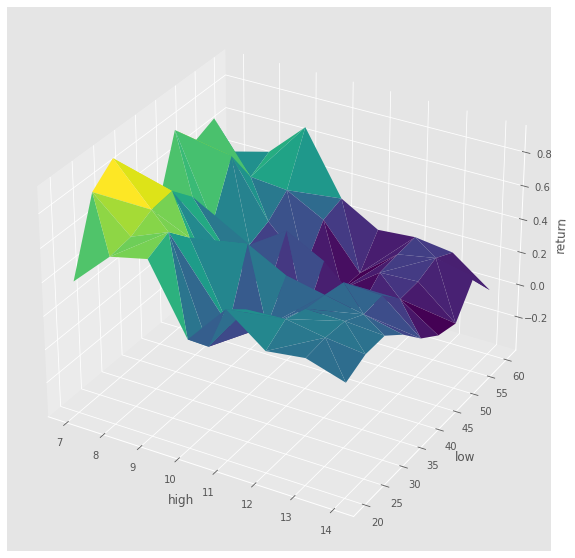

In [49]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(optimizationList.window, optimizationList.lookback, optimizationList.ret, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('high')
ax.set_ylabel('low')
ax.set_zlabel('return')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_11136\2934912639.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


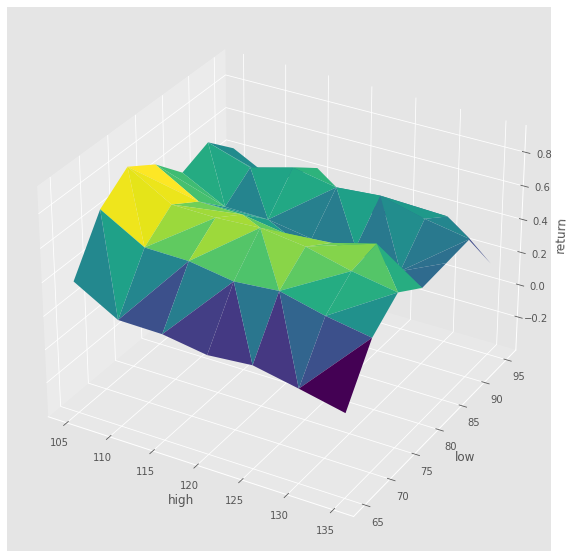

In [50]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(optimizationList.high, optimizationList.low, optimizationList.ret, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('high')
ax.set_ylabel('low')
ax.set_zlabel('return')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_11136\3864874376.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


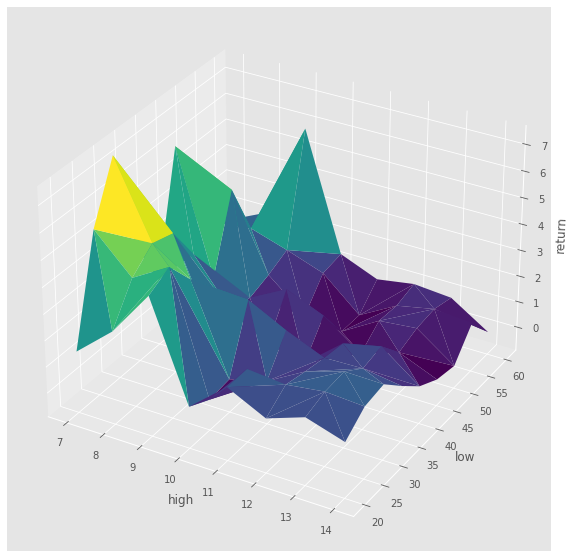

In [52]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(optimizationList.window, optimizationList.lookback, optimizationList.calmarRatio, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('high')
ax.set_ylabel('low')
ax.set_zlabel('return')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_11136\2961654477.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


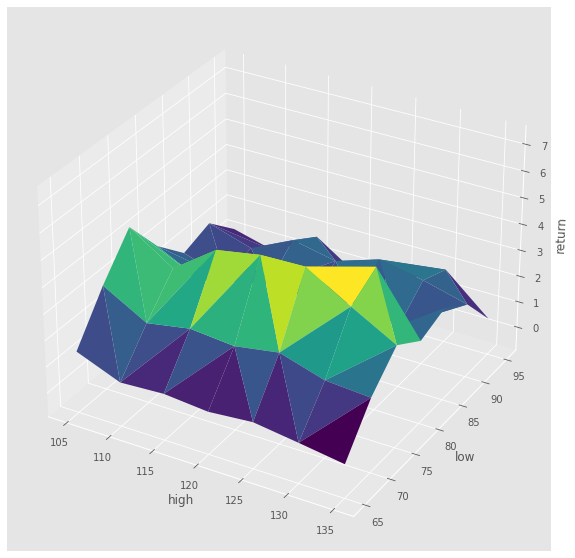

In [53]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(optimizationList.high, optimizationList.low, optimizationList.calmarRatio, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('high')
ax.set_ylabel('low')
ax.set_zlabel('return')
plt.show()

# 樣本外測試

In [74]:
fund = 1000000
feePaid = 600
K = 0.04
d = 0.02
plus = talib.PLUS_DI(testData['High'], testData['Low'], testData['Close'], timeperiod=7)
minus = talib.MINUS_DI(testData['High'], testData['Low'], testData['Close'], timeperiod=7)
testData['diff'] = plus - minus
testData['diff_avg'] = talib.SMA(testData['diff'], timeperiod=30)
testData['ADX'] = talib.ADX(testData['High'], testData['Low'], testData['Close'], timeperiod=7)
df_arr = np.array(testData)
time_arr = np.array(testData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

In [75]:
testData.tail(10)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio,diff,diff_avg,ADX
2022-05-09,16156.0,16194.0,16015.0,16027.0,98847,-8165,76.32,-32.690828,-16.749519,35.078779
2022-05-10,15809.0,16045.0,15730.0,16039.0,127144,-12886,81.12,-42.173712,-18.411835,38.301838
2022-05-11,15989.0,16058.0,15907.0,16010.0,87439,-9158,83.17,-37.904774,-19.990413,40.823863
2022-05-12,15801.0,15890.0,15608.0,15632.0,117996,-6639,80.32,-45.456138,-21.203892,44.387489
2022-05-13,15777.0,15854.0,15743.0,15851.0,95043,-5519,88.14,-40.106348,-22.381282,47.442025
2022-05-16,15996.0,16044.0,15847.0,15921.0,97948,-2540,89.74,-25.275253,-23.459124,46.233953
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752,91,96.15,-19.711775,-24.250842,44.224396
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713,1701,103.66,-4.070890,-24.043195,38.794292
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113,400,88.47,-20.356658,-24.239857,37.612278
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478,5593,96.77,-8.469318,-23.747969,34.019717


              profit  profitfee
2020-01-02       0.0        0.0
2020-01-03       0.0        0.0
2020-01-06       0.0        0.0
2020-01-07       0.0        0.0
2020-01-08       0.0        0.0
...              ...        ...
2022-05-16  450400.0   408400.0
2022-05-17  450400.0   408400.0
2022-05-18  450400.0   408400.0
2022-05-19  450400.0   408400.0
2022-05-20  450400.0   408400.0

[578 rows x 2 columns]


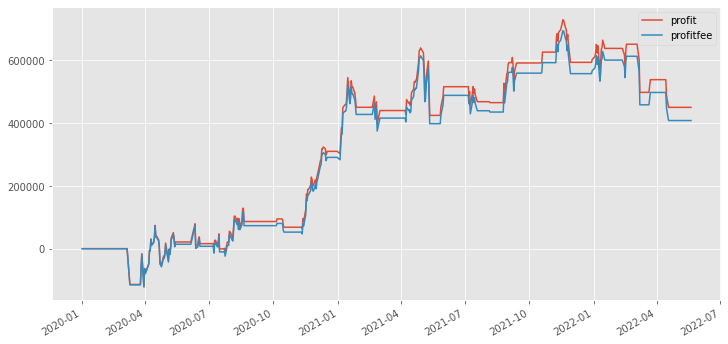

In [76]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = (df_arr[i,7] > df_arr[i,8]) & (df_arr[i,6] >= 105) & (df_arr[i,-1] > 25)
    entrySellShort = (df_arr[i,7] < df_arr[i,8]) & (df_arr[i,6] <= 75) & (df_arr[i,-1] > 25)
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = ((df_arr[i,7] <= df_arr[i,8]) & (df_arr[i,6] <= 75)) or (df_arr[i,-1] <= 25)
    exitBuyToCover = ((df_arr[i,7] >= df_arr[i,8]) & (df_arr[i,6] >= 105)) or (df_arr[i,-1] <= 25)
    exitCondition = date_arr[i] in settlementDate  ####
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-d)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+d)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=testData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));

In [77]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

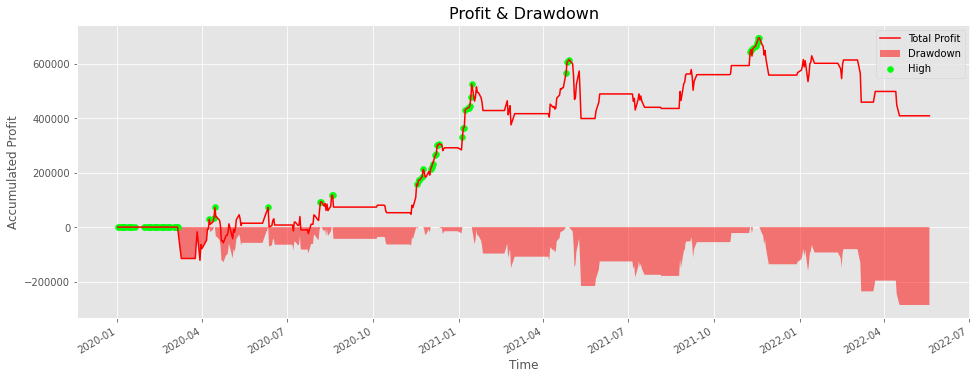

In [78]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

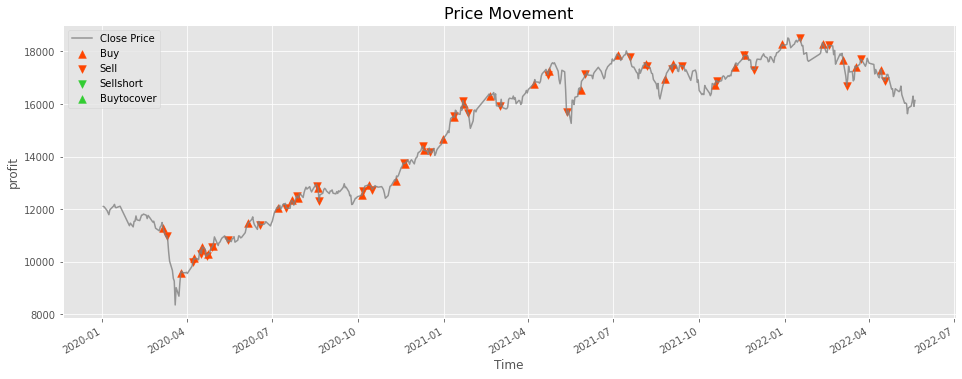

In [79]:
fig, ax = plt.subplots(figsize = (16,6))

testData['Close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(testData['Close'].iloc[buy].index, testData['Close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(testData['Close'].iloc[sell].index, testData['Close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(testData['Close'].iloc[sellshort].index, testData['Close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(testData['Close'].iloc[buytocover].index, testData['Close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('profit')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [80]:
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $408400.0
return: 40.839999999999996%
mdd: 16.869999999999997%
calmarRatio: 2.42
tradeTimes: 35
winRate: 54.290000000000006%
profitFactor: 1.44
winLossRatio: 1.21
